# txxxx

deep learning klaar

## Modules Importeren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import optuna

2024-08-13 10:11:36.200025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Laden

In [3]:
atussum_2016 = pd.read_csv('atussum_2016.csv')
atussum_2017 = pd.read_csv('atussum_2017.csv')
atussum_2018 = pd.read_csv('atussum_2018.csv')
atussum_2019 = pd.read_csv('atussum_2019.csv')
atussum_2022 = pd.read_csv('atussum_2022.csv')

df_list = [atussum_2016, atussum_2017, atussum_2018, atussum_2019]

combined_df = pd.concat(df_list, ignore_index=True)

print(combined_df.head())

print(combined_df.shape)

         TUCASEID     TUFINLWGT  TRYHHCHILD  TEAGE  TESEX  PEEDUCA  PTDTRACE  \
0  20160101160045  2.458865e+07          -1     62      2       39         1   
1  20160101160066  5.445941e+06          -1     69      1       37         2   
2  20160101160069  8.782622e+06           0     24      2       39         2   
3  20160101160083  3.035910e+06           8     31      2       40         1   
4  20160101160084  6.978586e+06          -1     59      2       39         1   

   PEHSPNON  GTMETSTA  TELFS  ...  t119999  t130115  t130123  t130399  \
0         2         1      5  ...      NaN      NaN      NaN      NaN   
1         2         2      5  ...      NaN      NaN      NaN      NaN   
2         2         1      5  ...      NaN      NaN      NaN      NaN   
3         2         2      1  ...      NaN      NaN      NaN      NaN   
4         2         1      1  ...      NaN      NaN      NaN      NaN   

   t130402  t150899  t019999  t060402  t090302  t180599  
0      NaN      NaN   

## Data Preparation

In [4]:
asum1 = combined_df[(combined_df['TRERNWA'] != -1)]
asum1.loc[:, 'TRERNWA'] = asum1['TRERNWA'] / 100
df = asum1.fillna(0)


def sum_columns_with_prefix(df, prefix):
    cols_to_sum = [col for col in df.columns if col.startswith(prefix)]
    if cols_to_sum:
        return df[cols_to_sum].sum(axis=1)
    else:
        return pd.Series([0] * len(df), index=df.index)

prefixes = ['t0101', 't0102', 't0103', 't0104', 't0199', 
            't0201', 't0202', 't0203', 't0204', 't0205', 't0206', 't0207', 't0208', 't0209', 't0299', 
            't0301', 't0302', 't0303', 't0304', 't0305', 't0399',
            't0401', 't0402', 't0403', 't0404', 't0405', 't0499',
            't0501', 't0502', 't0503', 't0504', 't0599', 
            't0601', 't0602', 't0603', 't0604', 't0699', 
            't0701', 't0702', 't0703', 't0799', 
            't0801', 't0802', 't0803', 't0804', 't0805', 't0806', 't0807', 't0808', 't0899', 
            't0901', 't0902', 't0903', 't0904', 't0905', 't0999',
            't1001', 't1002', 't1003', 't1004', 't1099', 
            't1101', 't1102', 't1199',
            't1201', 't1202', 't1203', 't1204', 't1205', 't0299', 
            't1301', 't1302', 't1303', 't1304', 't0399',
            't1401', 't1499',
            't1501', 't1502', 't1503', 't1504', 't1505', 't1506', 't1507', 't1508', 't0299',
            't1601', 't1602', 't1699',
            't1801', 't1802', 't1803', 't1804', 't1805', 't1806', 't1807', 't1808', 't1809', 't1810', 't1811', 't1812', 't1813', 't1814', 't1815', 't1816', 't1817', 't1818', 't1899', ]

sum_columns_dict = {}
for prefix in prefixes:
    sum_columns_dict[f'{prefix}_sum'] = sum_columns_with_prefix(df, prefix)

columns_to_retain = ['TRYHHCHILD', 'TEAGE', 'TESEX','PEEDUCA', 'PTDTRACE', 'PEHSPNON', 'GTMETSTA',
'TELFS', 'TEMJOT', 'TRDPFTPT', 'TESCHENR', 'TESCHLVL', 'TRSPPRES', 'TESPEMPNOT', 'TRERNWA', 'TRCHILDNUM', 'TRSPFTPT', 'TEHRUSLT']

sum_df = pd.DataFrame(sum_columns_dict)
sum_df[columns_to_retain] = df[columns_to_retain]
df = sum_df

print(df.shape)
df.head()

(21361, 123)


,t0101_sum,t0102_sum,t0103_sum,t0104_sum,t0199_sum,t0201_sum,t0202_sum,t0203_sum,t0204_sum,t0205_sum,...,TEMJOT,TRDPFTPT,TESCHENR,TESCHLVL,TRSPPRES,TESPEMPNOT,TRERNWA,TRCHILDNUM,TRSPFTPT,TEHRUSLT
3,635.0,20,0,0,0.0,195,140,60,0,0.0,...,2,2,2,-1,3,-1,469.44,3,-1,32
4,500.0,80,0,0,0.0,55,0,0,0,0.0,...,1,2,-1,-1,1,2,302.50,0,-1,12
10,778.0,60,0,0,0.0,0,90,0,0,0.0,...,2,1,2,-1,1,1,1538.46,2,1,55
11,480.0,75,0,0,0.0,0,20,0,0,0.0,...,2,1,-1,-1,2,2,1211.53,2,-1,38
12,625.0,45,0,0,0.0,180,30,0,0,0.0,...,2,1,2,-1,3,-1,961.53,0,-1,40


In [5]:
df2022 = atussum_2022[(atussum_2022['TRERNWA'] != -1)]
df2022.loc[:, 'TRERNWA'] = df2022['TRERNWA'] / 100
df2022 = df2022.fillna(0)


def sum_columns_with_prefix(df, prefix):
    cols_to_sum = [col for col in df.columns if col.startswith(prefix)]
    if cols_to_sum:
        return df[cols_to_sum].sum(axis=1)
    else:
        return pd.Series([0] * len(df), index=df.index)


sum_columns_dict = {}
for prefix in prefixes:
    sum_columns_dict[f'{prefix}_sum'] = sum_columns_with_prefix(df2022, prefix)

sum_df = pd.DataFrame(sum_columns_dict)
sum_df[columns_to_retain] = df2022[columns_to_retain]
df2022= sum_df


print(df2022.shape)
df2022.head()

(4226, 123)


,t0101_sum,t0102_sum,t0103_sum,t0104_sum,t0199_sum,t0201_sum,t0202_sum,t0203_sum,t0204_sum,t0205_sum,...,TEMJOT,TRDPFTPT,TESCHENR,TESCHLVL,TRSPPRES,TESPEMPNOT,TRERNWA,TRCHILDNUM,TRSPFTPT,TEHRUSLT
1,540,70,330,0,0,0,25,0,0,0,...,2,1,2,-1,1,1,640.00,0,1,40
7,540,30,0,0,0,250,0,0,0,0,...,2,1,-1,-1,3,-1,1750.00,1,-1,55
8,90,2,1305,0,0,0,3,0,0,0,...,2,1,-1,-1,1,1,769.23,0,1,40
10,360,60,0,0,0,0,0,0,0,0,...,2,1,2,-1,1,1,520.00,0,2,40
15,360,30,0,0,0,0,10,0,0,0,...,2,1,2,-1,2,2,1615.38,1,-1,50


In [6]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train = train_set.drop("TRERNWA", axis=1)
y_train = train_set["TRERNWA"]
X_test = test_set.drop("TRERNWA", axis=1)
y_test = test_set["TRERNWA"]

In [7]:
X_2022 = df2022.drop("TRERNWA", axis=1)
y_2022 = df2022["TRERNWA"]

## Modellen

### Klassieke Statistische Modellen

#### Lineaire Regressie


Test MAE: 435.52604471087625
R2 Score: 0.42695382600792753
______

2022 MAE: 1771159.9822002682
2022 R2 Score: -11018102262.65512



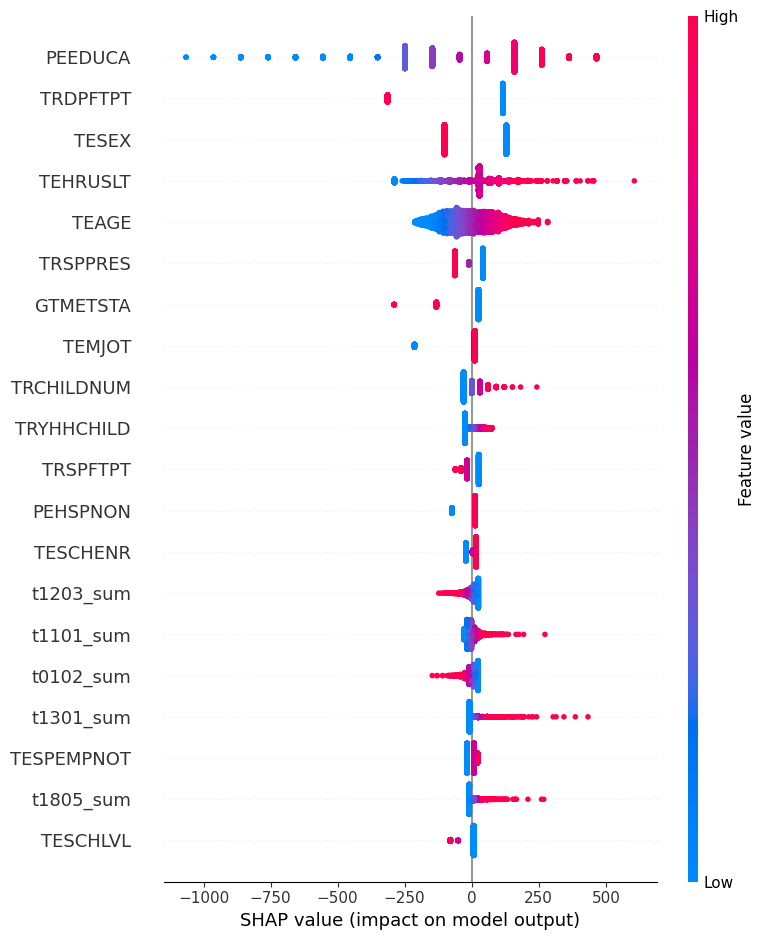

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Ridge Regressie

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 435.29327868176773
R2 Score: 0.4273402949824049
______

2022 MAE: 487.2831461187011
2022 R2 Score: 0.35270042462920903



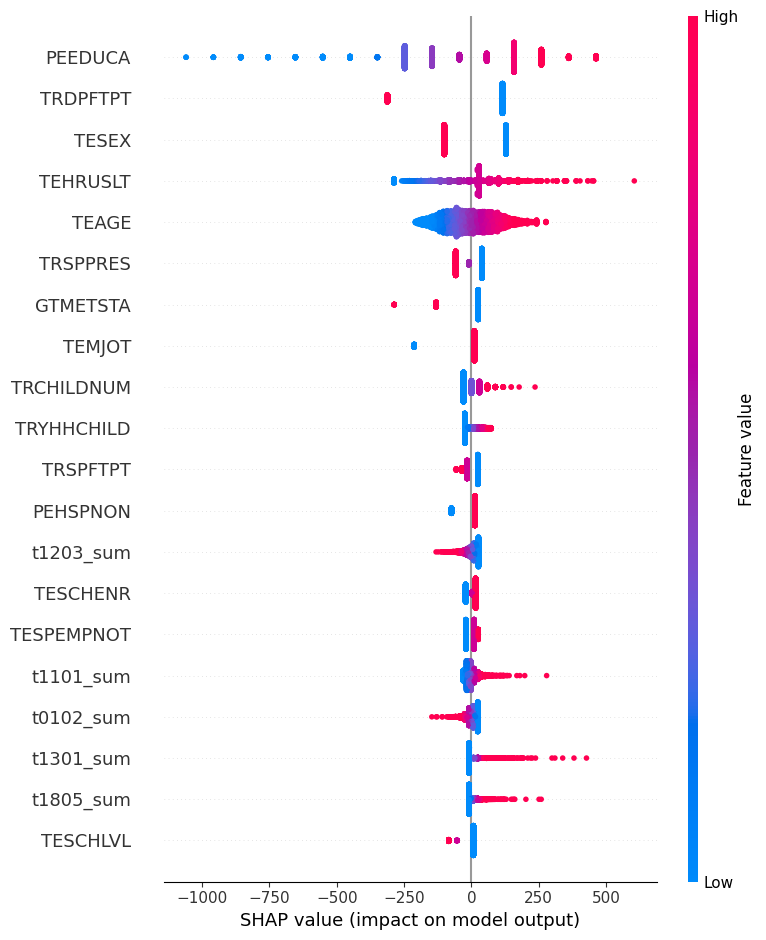

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

ridge_model = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_scaled, y_train)

y_pred = best_ridge_model.predict(X_test_scaled)
y_pred2022 = best_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Lasso Regressie

Beste hyperparameters: {'alpha': 10.0}

Test MAE: 435.902869565856
R2 Score: 0.42262917610567463
______

2022 MAE: 487.4717192027128
2022 R2 Score: 0.3498406418197506



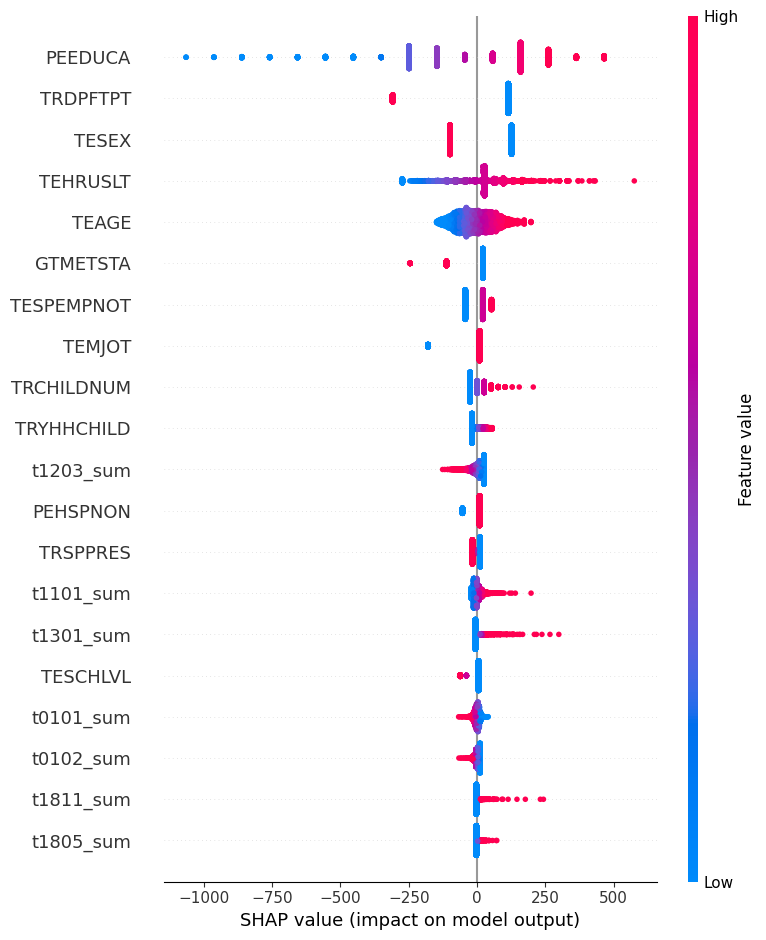

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

lasso_model = Lasso()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_scaled, y_train)

y_pred = best_lasso_model.predict(X_test_scaled)
y_pred2022 = best_lasso_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_lasso_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Bayesian Ridge Regression


Test MAE: 435.2002010680221
R2 Score: 0.4272579461186814
______

2022 MAE: 487.27167203973215
2022 R2 Score: 0.35211821166879087



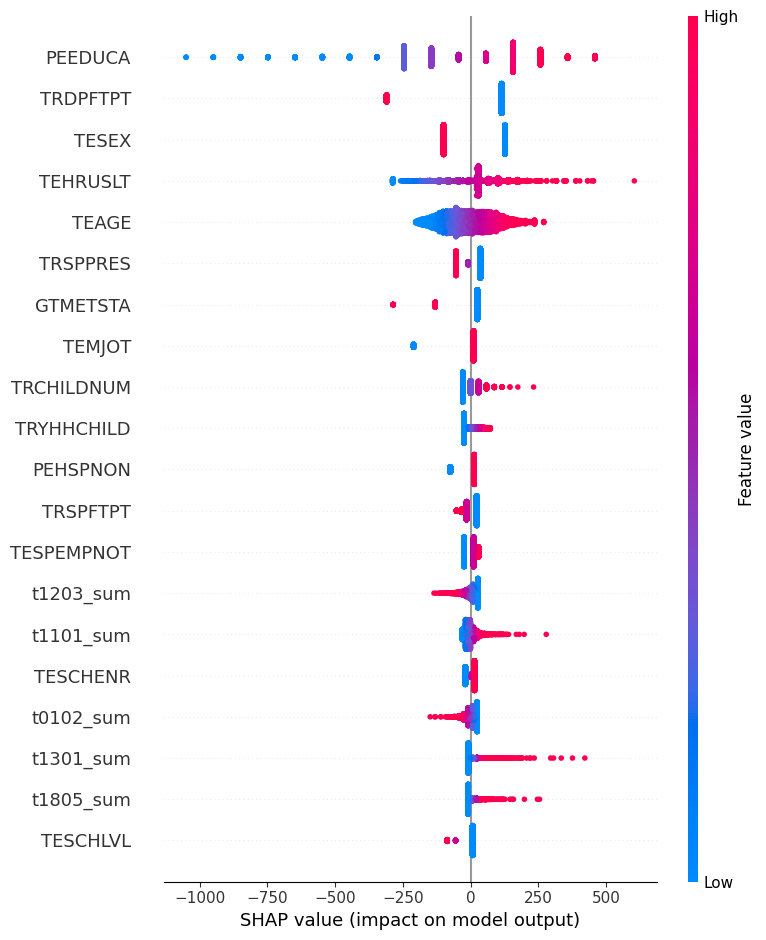

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_scaled, y_train)

y_pred = bayesian_ridge_model.predict(X_test_scaled)
y_pred2022 = bayesian_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(bayesian_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

### Machine Learning Modellen

#### Decision Tree

Beste hyperparameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10}

Test MAE: 407.04376691657586
R2 Score: 0.44535074700489385
______

2022 MAE: 455.88500848973666
2022 R2 Score: 0.38867130977550024



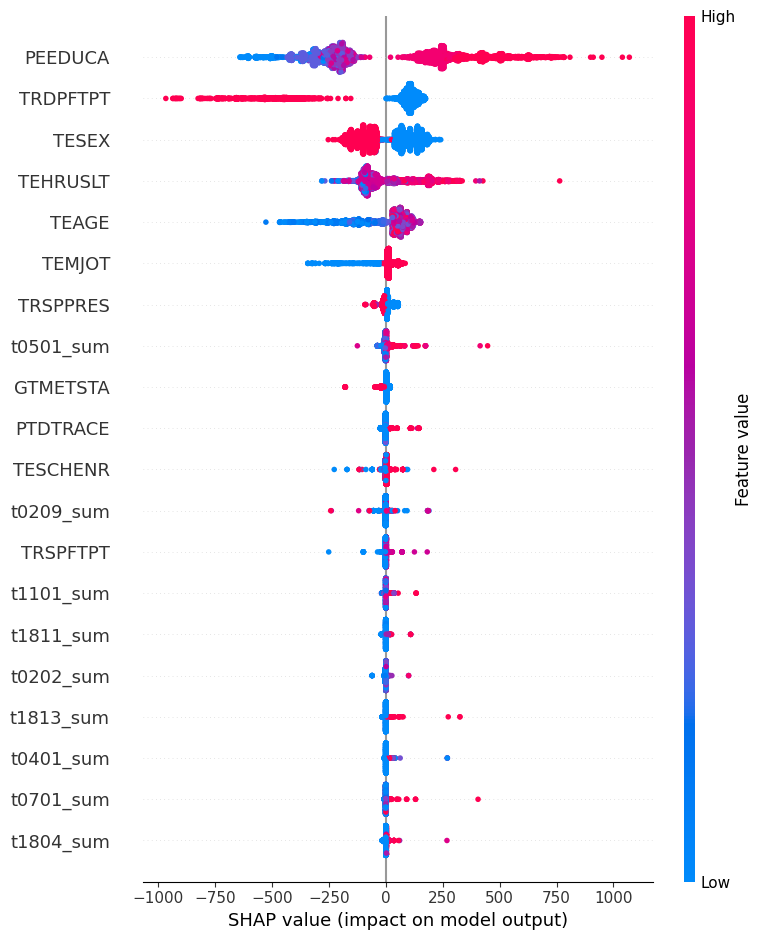

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

tree_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_scaled, y_train)

y_pred = best_tree_model.predict(X_test_scaled)
y_pred2022 = best_tree_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_tree_model)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Random Forests

Beste hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Test MAE: 388.72714395854126
R2 Score: 0.49569987437449703
______

2022 MAE: 442.44798453612447
2022 R2 Score: 0.4182358797499971



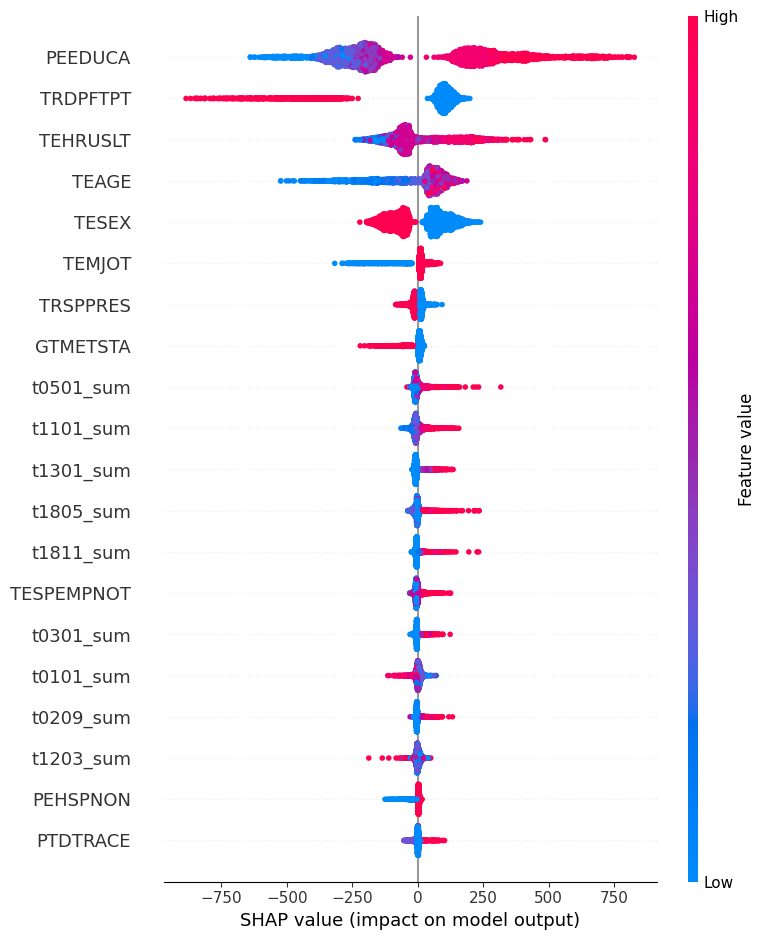

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

rf_model = RandomForestRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_scaled, y_train)

y_pred = best_rf_model.predict(X_test_scaled)
y_pred2022 = best_rf_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_rf_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

#### Gradient Boosting Machines (GBM)

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Test MAE: 383.4640218195435
R2 Score: 0.5156621016099008
______

2022 MAE: 438.26437505046016
2022 R2 Score: 0.4354504500236518



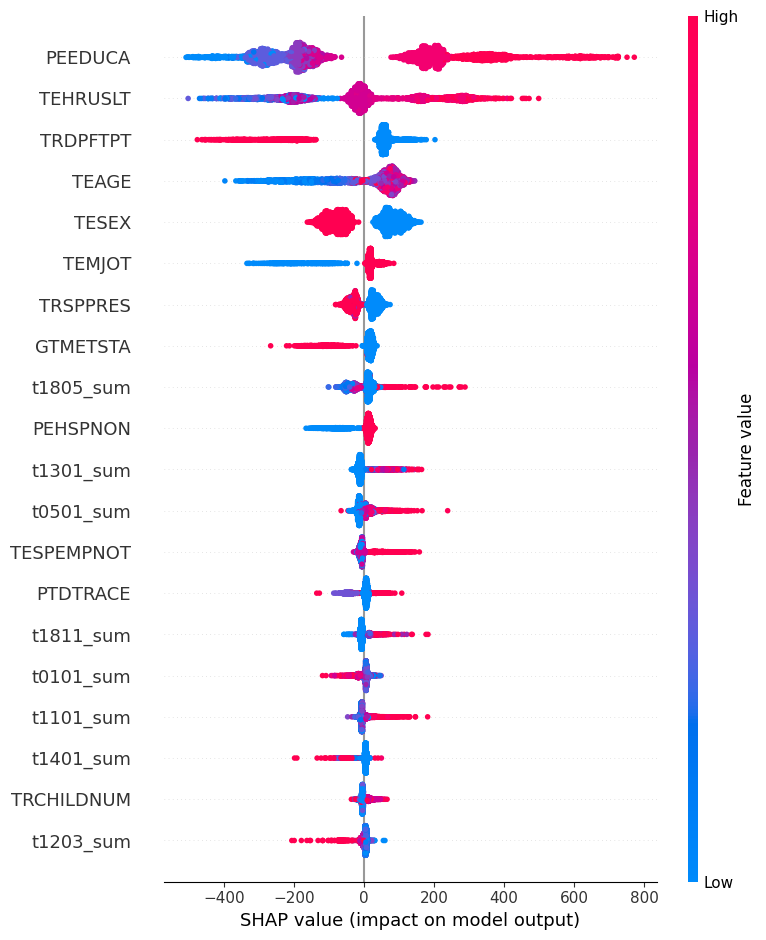

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

gbr_model = GradientBoostingRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_scaled, y_train)

y_pred = best_gbr_model.predict(X_test_scaled)
y_pred2022 = best_gbr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_gbr_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

#### Support Vector Machines (SVM)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

svr_model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_scaled, y_train)

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}


SVR(C=100, epsilon=0.01)


Test MAE: 414.6893213436352
R2 Score: 0.3923619254647255
______

2022 MAE: 503.8834195341963
2022 R2 Score: 0.23523870130114044



  0%|          | 0/100 [00:00<?, ?it/s]

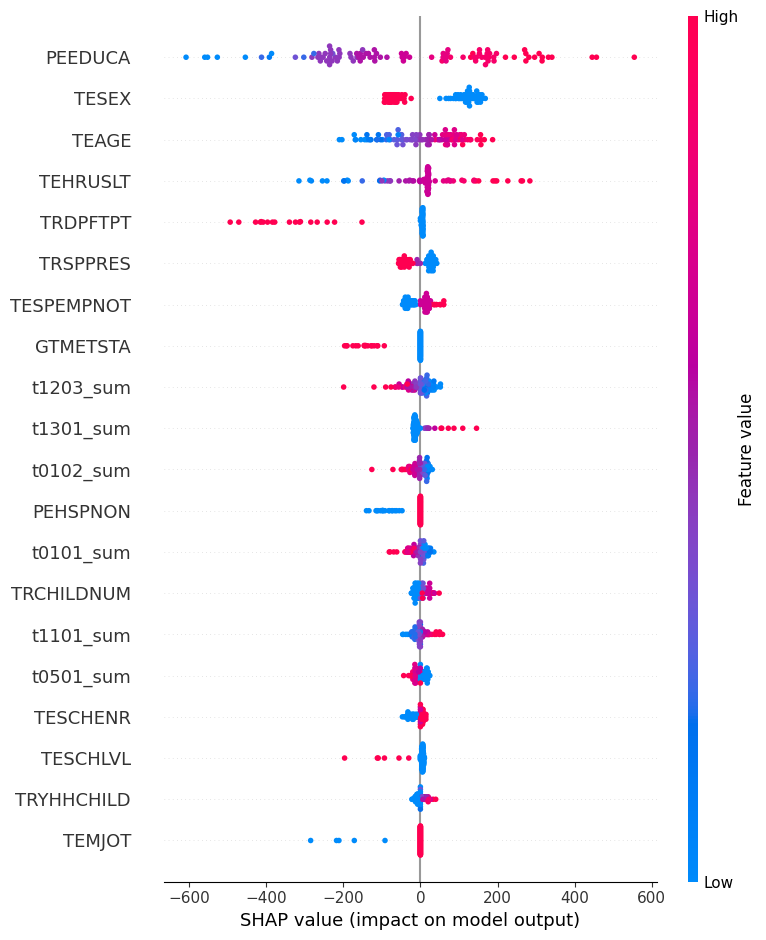

In [14]:
y_pred = best_svr_model.predict(X_test_scaled)
y_pred2022 = best_svr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

background = shap.kmeans(X_train_scaled, 50)  
subset_size = 100
X_test_scaled_subset, y_test_subset = shuffle(X_test_scaled, y_test, random_state=1, n_samples=subset_size)

explainer = shap.KernelExplainer(best_svr_model.predict, background)
shap_values_test = explainer.shap_values(X_test_scaled_subset)

shap.summary_plot(shap_values_test, X_test_scaled_subset, feature_names=X_train.columns)
plt.show()

#### K-Nearest Neighbors (KNN)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_scaled, y_train)

Beste hyperparameters: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'distance'}


KNeighborsRegressor(n_neighbors=11, weights='distance')

In [16]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

y_pred = best_knn_model.predict(X_test_scaled)
y_pred2022 = best_knn_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")


Test MAE: 475.460438203139
R2 Score: 0.3082499893922578
______

2022 MAE: 524.2098323664019
2022 R2 Score: 0.23577635535272912



### Deep Learning Modellen

Epoch 1/100


2024-08-13 10:12:17.305867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


428/428 [==============================] - 1s 1ms/step - loss: 1096163.8750 - mae: 790.6956 - val_loss: 396913.4375 - val_mae: 459.3805
Epoch 2/100
428/428 [==============================] - 0s 887us/step - loss: 355176.8125 - mae: 440.9690 - val_loss: 336505.0312 - val_mae: 427.4811
Epoch 3/100
428/428 [==============================] - 0s 862us/step - loss: 332249.0938 - mae: 428.1228 - val_loss: 329797.4375 - val_mae: 422.6386
Epoch 4/100
428/428 [==============================] - 0s 842us/step - loss: 324457.2500 - mae: 423.0652 - val_loss: 326970.8438 - val_mae: 421.0447
Epoch 5/100
428/428 [==============================] - 0s 940us/step - loss: 319370.9062 - mae: 419.7751 - val_loss: 325153.8438 - val_mae: 417.8544
Epoch 6/100
428/428 [==============================] - 0s 867us/step - loss: 315788.5625 - mae: 416.7069 - val_loss: 322646.2188 - val_mae: 419.1538
Epoch 7/100
428/428 [==============================] - 0s 865us/step - loss: 312245.1562 - mae: 414.7258 - val_loss: 32

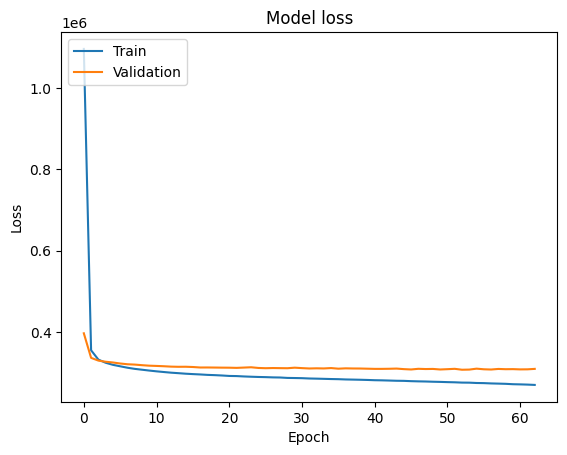

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

PermutationExplainer explainer: 4274it [01:12, 52.32it/s]                       


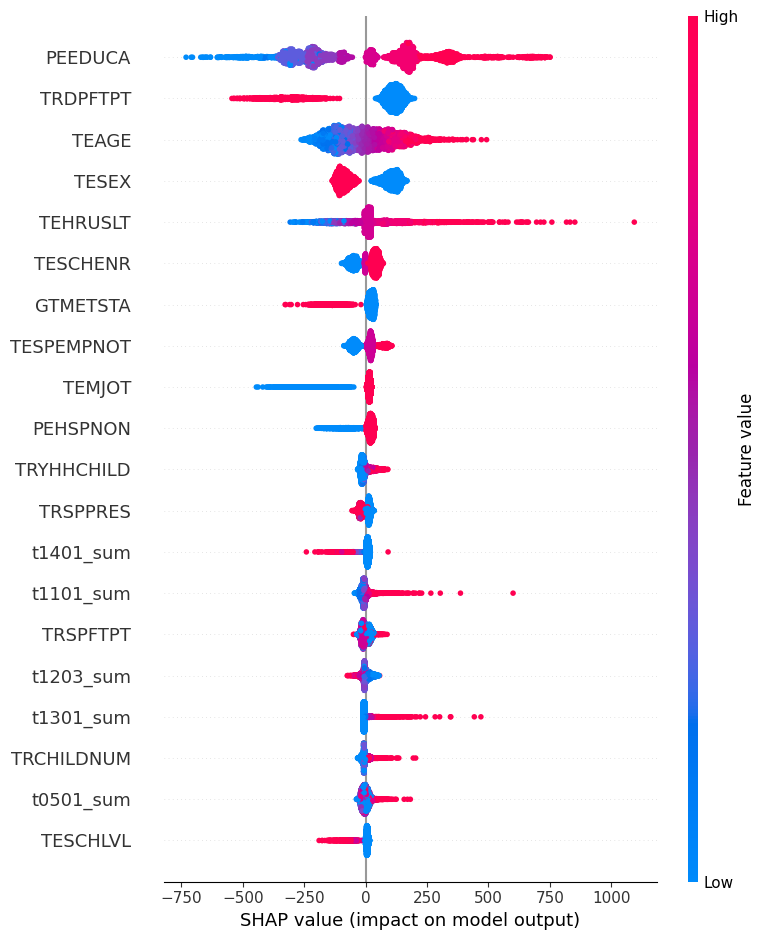

In [9]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

#### Hyperparameter Tuning: Random Search

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

class IncomePredictionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model

tuner = RandomSearch(
    IncomePredictionHyperModel(),
    objective='val_mae',
    max_trials=10, 
    executions_per_trial=2, 
    directory='my_dir',
    project_name='income_prediction6'
)

tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(patience=10)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[EarlyStopping(patience=10)])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Reloading Tuner from my_dir/income_prediction6/tuner0.json
Epoch 1/50
214/214 [==============================] - 1s 3ms/step - loss: 573985.8125 - mae: 540.6304 - val_loss: 345646.9688 - val_mae: 426.3864
Epoch 2/50
214/214 [==============================] - 1s 2ms/step - loss: 336471.3125 - mae: 426.2375 - val_loss: 331622.1875 - val_mae: 416.4650
Epoch 3/50
214/214 [==============================] - 0s 2ms/step - loss: 318813.5000 - mae: 417.2082 - val_loss: 324336.2188 - val_mae: 423.8702
Epoch 4/50
214/214 [==============================] - 0s 2ms/step - loss: 307590.0000 - mae: 409.9628 - val_loss: 318324.0312 - val_mae: 408.7072
Epoch 5/50
214/214 [==============================] - 0s 2ms/step - loss: 301117.7500 - mae: 404.8332 - val_loss: 315228.8438 - val_mae: 404.4174
Epoch 6/50
214/214 [==============================] - 0s 2ms/step - loss: 293176.7812 - mae: 399.3470 - val_loss: 313210.2812 - val_mae: 413.1382
Epoch 7/50
214/214 [==============================] - 0s 2ms/step

PermutationExplainer explainer: 4274it [05:04, 13.58it/s]                       


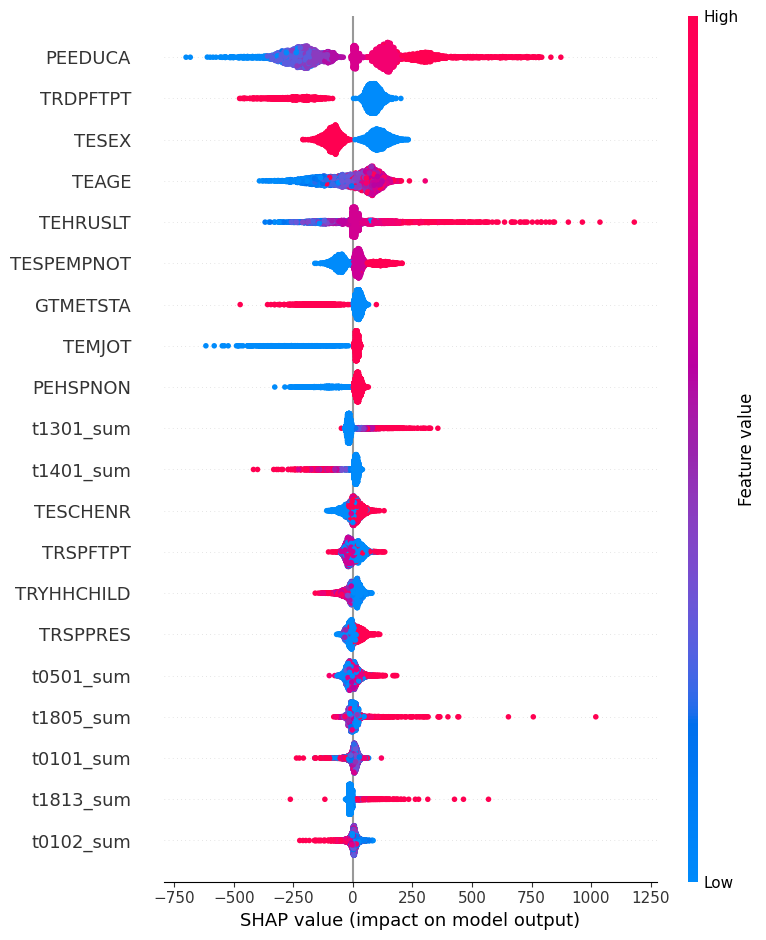

In [11]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Optuna

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

def create_model(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 16, 128, step=16)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_shape=(X_train_scaled.shape[1],)))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units, activation=activation))

    model.add(Dense(1))

    optimizer = optimizer_name
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)


y_pred = best_model.predict(X_test_scaled)
y_pred2022 = best_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

[I 2024-08-13 10:19:09,621] A new study created in memory with name: no-name-c3d59240-1de6-478f-82b7-3bc577db6f3e


134/134 [==============================] - 0s 458us/step


[I 2024-08-13 10:19:18,021] Trial 0 finished with value: 1024.3745872010807 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 2.132829614107297e-05}. Best is trial 0 with value: 1024.3745872010807.


134/134 [==============================] - 0s 472us/step


[I 2024-08-13 10:19:25,166] Trial 1 finished with value: 411.1112178917297 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0024528872534639564}. Best is trial 1 with value: 411.1112178917297.


134/134 [==============================] - 0s 464us/step


[I 2024-08-13 10:19:35,901] Trial 2 finished with value: 1029.4138897209557 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 1.0265866283814984e-05}. Best is trial 1 with value: 411.1112178917297.


134/134 [==============================] - 0s 420us/step


[I 2024-08-13 10:19:43,551] Trial 3 finished with value: 951.973152698666 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0002624276563308219}. Best is trial 1 with value: 411.1112178917297.


134/134 [==============================] - 0s 458us/step


[I 2024-08-13 10:19:52,803] Trial 4 finished with value: 1026.7035949073388 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 1.4046267543633558e-05}. Best is trial 1 with value: 411.1112178917297.


134/134 [==============================] - 0s 404us/step


[I 2024-08-13 10:20:01,204] Trial 5 finished with value: 1036.0191943647449 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 2.92792790350386e-05}. Best is trial 1 with value: 411.1112178917297.


134/134 [==============================] - 0s 430us/step


[I 2024-08-13 10:20:09,640] Trial 6 finished with value: 417.2768823784351 and parameters: {'num_layers': 1, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001619695612673411}. Best is trial 1 with value: 411.1112178917297.


134/134 [==============================] - 0s 437us/step


[I 2024-08-13 10:20:18,118] Trial 7 finished with value: 1039.1754131867972 and parameters: {'num_layers': 1, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 2.2727179815926358e-05}. Best is trial 1 with value: 411.1112178917297.


134/134 [==============================] - 0s 437us/step


[I 2024-08-13 10:20:27,008] Trial 8 finished with value: 410.0016967382594 and parameters: {'num_layers': 1, 'num_units': 112, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.004010025003967557}. Best is trial 8 with value: 410.0016967382594.


134/134 [==============================] - 0s 439us/step


[I 2024-08-13 10:20:35,505] Trial 9 finished with value: 920.4784272170385 and parameters: {'num_layers': 1, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00017338234457429504}. Best is trial 8 with value: 410.0016967382594.


134/134 [==============================] - 0s 506us/step


[I 2024-08-13 10:20:40,202] Trial 10 finished with value: 406.02109199979225 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.008726744068285988}. Best is trial 10 with value: 406.02109199979225.


134/134 [==============================] - 0s 499us/step


[I 2024-08-13 10:20:45,383] Trial 11 finished with value: 408.04115090394953 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.009124922207496068}. Best is trial 10 with value: 406.02109199979225.


134/134 [==============================] - 0s 500us/step


[I 2024-08-13 10:20:49,347] Trial 12 finished with value: 404.7842673452972 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0091338903801951}. Best is trial 12 with value: 404.7842673452972.


134/134 [==============================] - 0s 501us/step


[I 2024-08-13 10:20:56,951] Trial 13 finished with value: 407.89859335879936 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0010324152523756786}. Best is trial 12 with value: 404.7842673452972.


134/134 [==============================] - 0s 478us/step


[I 2024-08-13 10:21:01,089] Trial 14 finished with value: 409.75787226410233 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.009722215012134286}. Best is trial 12 with value: 404.7842673452972.


134/134 [==============================] - 0s 481us/step


[I 2024-08-13 10:21:10,780] Trial 15 finished with value: 414.2755418165182 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0006704069562286643}. Best is trial 12 with value: 404.7842673452972.


134/134 [==============================] - 0s 518us/step


[I 2024-08-13 10:21:23,526] Trial 16 finished with value: 419.8680996233447 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 8.094276784083026e-05}. Best is trial 12 with value: 404.7842673452972.


134/134 [==============================] - 0s 492us/step


[I 2024-08-13 10:21:27,407] Trial 17 finished with value: 403.1971495918543 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.004751439495261514}. Best is trial 17 with value: 403.1971495918543.


134/134 [==============================] - 0s 470us/step


[I 2024-08-13 10:21:32,824] Trial 18 finished with value: 405.3189633542951 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0036769718360209675}. Best is trial 17 with value: 403.1971495918543.


134/134 [==============================] - 0s 522us/step


[I 2024-08-13 10:21:44,892] Trial 19 finished with value: 415.00579815599195 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0004905023444212494}. Best is trial 17 with value: 403.1971495918543.


134/134 [==============================] - 0s 474us/step


[I 2024-08-13 10:21:49,336] Trial 20 finished with value: 406.6769464585554 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.004521170723346336}. Best is trial 17 with value: 403.1971495918543.


134/134 [==============================] - 0s 474us/step


[I 2024-08-13 10:21:54,749] Trial 21 finished with value: 406.9589559690126 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.003589561052453945}. Best is trial 17 with value: 403.1971495918543.


134/134 [==============================] - 0s 492us/step


[I 2024-08-13 10:22:00,451] Trial 22 finished with value: 411.6245471596578 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.001494751890838827}. Best is trial 17 with value: 403.1971495918543.


134/134 [==============================] - 0s 484us/step


[I 2024-08-13 10:22:04,773] Trial 23 finished with value: 410.5666065330158 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.005243036850968857}. Best is trial 17 with value: 403.1971495918543.


134/134 [==============================] - 0s 477us/step


[I 2024-08-13 10:22:10,164] Trial 24 finished with value: 407.8590604577577 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.002645565621059447}. Best is trial 17 with value: 403.1971495918543.


134/134 [==============================] - 0s 448us/step


[I 2024-08-13 10:22:15,398] Trial 25 finished with value: 405.2558754238858 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0058952982081636116}. Best is trial 17 with value: 403.1971495918543.


134/134 [==============================] - 0s 450us/step


[I 2024-08-13 10:22:21,786] Trial 26 finished with value: 401.3354129917851 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006273371898640726}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 446us/step


[I 2024-08-13 10:22:27,115] Trial 27 finished with value: 406.79307780474045 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0017775651700051053}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 454us/step


[I 2024-08-13 10:22:33,277] Trial 28 finished with value: 404.53708001984666 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006619512696115816}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 555us/step


[I 2024-08-13 10:22:43,737] Trial 29 finished with value: 407.856245795843 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0010315905156337637}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 436us/step


[I 2024-08-13 10:22:48,619] Trial 30 finished with value: 409.377468896353 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002443794052904177}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 455us/step


[I 2024-08-13 10:22:53,895] Trial 31 finished with value: 404.4682048972407 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006501105582504582}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 441us/step


[I 2024-08-13 10:22:58,761] Trial 32 finished with value: 404.834588035371 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.005842691052472327}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 443us/step


[I 2024-08-13 10:23:05,880] Trial 33 finished with value: 404.56349420320277 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002764751513685859}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 446us/step


[I 2024-08-13 10:23:10,920] Trial 34 finished with value: 407.23765934846625 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006671698044266255}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 444us/step


[I 2024-08-13 10:23:21,801] Trial 35 finished with value: 443.9830478159527 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.002075960159722229}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 453us/step


[I 2024-08-13 10:23:32,370] Trial 36 finished with value: 433.7873544326522 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 5.2090096610853504e-05}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 451us/step


[I 2024-08-13 10:23:42,945] Trial 37 finished with value: 459.2604804580585 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0011646351457162592}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 441us/step


[I 2024-08-13 10:23:52,575] Trial 38 finished with value: 435.6321896802774 and parameters: {'num_layers': 1, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00023249871392282243}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 394us/step


[I 2024-08-13 10:24:00,988] Trial 39 finished with value: 595.8137268545631 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.003327208487461405}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 438us/step


[I 2024-08-13 10:24:10,139] Trial 40 finished with value: 409.8343281104876 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0006649816362008956}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 439us/step


[I 2024-08-13 10:24:14,488] Trial 41 finished with value: 405.88359448305033 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006609375877789523}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 438us/step


[I 2024-08-13 10:24:21,479] Trial 42 finished with value: 403.80757055231487 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0026746247433159583}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 455us/step


[I 2024-08-13 10:24:27,736] Trial 43 finished with value: 408.9726422881902 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004806260032624265}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 449us/step


[I 2024-08-13 10:24:33,092] Trial 44 finished with value: 403.5997926065957 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.007113874241305859}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 467us/step


[I 2024-08-13 10:24:41,670] Trial 45 finished with value: 432.85323474329635 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.003782798775490914}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 463us/step


[I 2024-08-13 10:24:48,090] Trial 46 finished with value: 409.1153363519727 and parameters: {'num_layers': 1, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.009848890280798923}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 410us/step


[I 2024-08-13 10:24:58,137] Trial 47 finished with value: 410.52735884848784 and parameters: {'num_layers': 1, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0027131244963768016}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 430us/step


[I 2024-08-13 10:25:04,023] Trial 48 finished with value: 411.69394553425775 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0014231836399930546}. Best is trial 26 with value: 401.3354129917851.


134/134 [==============================] - 0s 452us/step


[I 2024-08-13 10:25:09,213] Trial 49 finished with value: 406.71375091213497 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.007237891986881142}. Best is trial 26 with value: 401.3354129917851.


FrozenTrial(number=26, state=TrialState.COMPLETE, values=[401.3354129917851], datetime_start=datetime.datetime(2024, 8, 13, 10, 22, 15, 398774), datetime_complete=datetime.datetime(2024, 8, 13, 10, 22, 21, 786290), params={'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006273371898640726}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'num_units': IntDistribution(high=128, log=False, low=16, step=16), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None)}, trial_id=26, value=None)
133/133 [==============================] - 0s 550us/step


Test MAE: 406.69235862798
R2 Score: 0.4318594602212079

______
2022 MAE: 465.88162695509646
2022 R2 Score: 0.36249735602032385


PermutationExplainer explainer: 4274it [01:28, 42.97it/s]                       


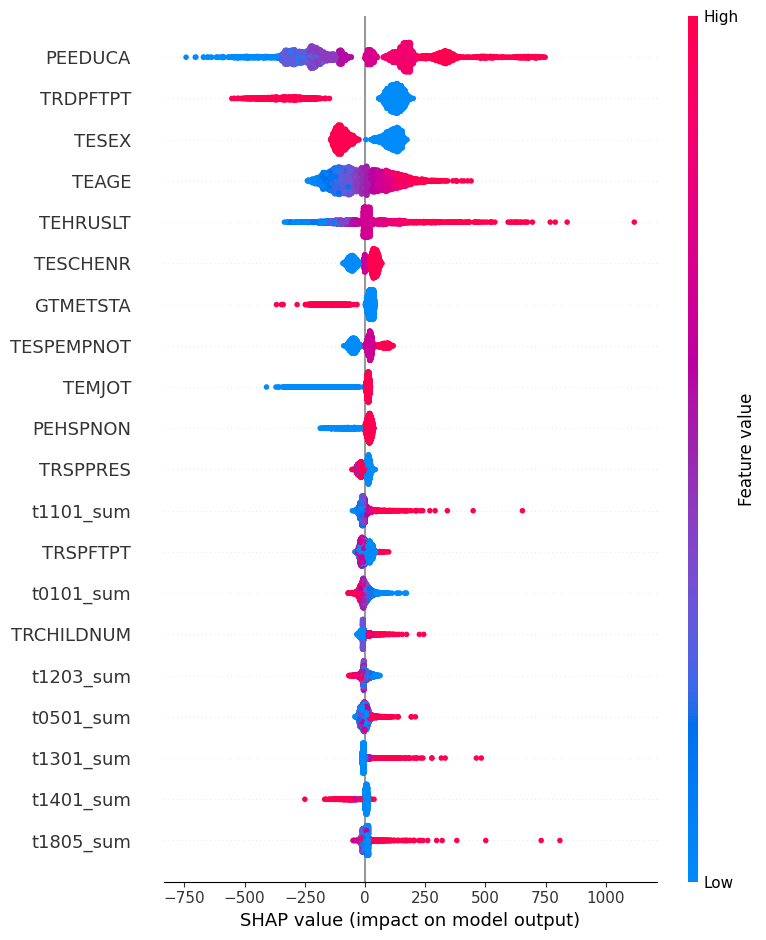

In [13]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

### 1D Convolutional Neural Network

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Epoch 1/100
428/428 [==============================] - 1s 3ms/step - loss: 772651.0000 - mae: 669.1312 - val_loss: 537628.0000 - val_mae: 577.4013
Epoch 2/100
428/428 [==============================] - 1s 3ms/step - loss: 532531.9375 - mae: 577.0333 - val_loss: 496735.8438 - val_mae: 559.3122
Epoch 3/100
428/428 [==============================] - 1s 3ms/step - loss: 474105.7500 - mae: 540.4366 - val_loss: 428140.7812 - val_mae: 501.9729
Epoch 4/100
428/428 [==============================] - 1s 3ms/step - loss: 410277.9375 - mae: 494.9309 - val_loss: 392721.0000 - val_mae: 471.1094
Epoch 5/100
428/428 [==============================] - 1s 2ms/step - loss: 385636.5625 - mae: 477.8122 - val_loss: 378270.2812 - val_mae: 458.4329
Epoch 6/100
428/428 [==============================] - 1s 2ms/step - loss: 373846.4688 - mae: 468.8289 - val_loss: 371479.2812 - val_mae: 455.5676
Epoch 7/100
428/428 [==============================] - 1s 2ms/step - loss: 365815.0625 - mae: 465.6524 - val_loss: 365

In [15]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_2022_cnn = X2022_scaled.reshape((X2022_scaled.shape[0], X2022_scaled.shape[1], 1))

def create_model(trial):
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    filters = trial.suggest_int('filters', 16, 128, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 128, step=16)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_cnn.shape[1], 1)))

    for _ in range(num_conv_layers - 1):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_cnn)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

[I 2024-08-13 10:28:05,526] A new study created in memory with name: no-name-901fc219-0742-42d6-b28e-a1b438bcaf60


134/134 [==============================] - 1s 4ms/step


[I 2024-08-13 10:30:38,301] Trial 0 finished with value: 592.889881626364 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.375665536244491, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.005722406357120433}. Best is trial 0 with value: 592.889881626364.


134/134 [==============================] - 1s 4ms/step


[I 2024-08-13 10:35:05,636] Trial 1 finished with value: 1001.9786009178814 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.035429357920187865, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 2.4261207762699718e-05}. Best is trial 0 with value: 592.889881626364.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 10:36:27,430] Trial 2 finished with value: 389.68519524464637 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.014933477346150137, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0003424822722031589}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 1s 4ms/step


[I 2024-08-13 10:37:41,273] Trial 3 finished with value: 408.26619599804116 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2579419226713187, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0017037177157633561}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 10:39:54,353] Trial 4 finished with value: 875.2061140852913 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.14010590497930953, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 8.209795916308482e-05}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 10:42:16,457] Trial 5 finished with value: 530.3655316959153 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.0865094341906093, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0002676425850442227}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 10:43:08,574] Trial 6 finished with value: 527.1098147410886 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.04951496433903124, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 3.1466727167894184e-05}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 10:44:32,285] Trial 7 finished with value: 927.5918906041027 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.013535005146602275, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.00010891363561247307}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 10:46:12,405] Trial 8 finished with value: 579.605195095956 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.11503933697206437, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 2.9436596058304406e-05}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 1s 4ms/step


[I 2024-08-13 10:48:49,174] Trial 9 finished with value: 592.6052789350921 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.08791729939301451, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.005165152401532413}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 10:50:11,511] Trial 10 finished with value: 395.474206480008 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2272959675221096, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.0008807907854559539}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 10:51:33,260] Trial 11 finished with value: 399.8373351320962 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.22485399955544055, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.0008869384132746244}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 10:52:54,562] Trial 12 finished with value: 409.97994132087234 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.487557597099904, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.000759245357430386}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 10:55:23,517] Trial 13 finished with value: 394.26960683259585 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.21511945767365104, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0003184483677135914}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 10:56:33,692] Trial 14 finished with value: 413.5291897068876 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3237745979342478, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.00018081009510575858}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 10:58:06,129] Trial 15 finished with value: 588.0873455137773 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.16822535042528608, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 1.02266715993844e-05}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 10:59:31,105] Trial 16 finished with value: 398.75682565245364 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4465492402630273, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0004273438425118038}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 1s 5ms/step


[I 2024-08-13 11:01:48,651] Trial 17 finished with value: 395.6887029758617 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.33461104090066063, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0023967304329410846}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:02:51,306] Trial 18 finished with value: 413.1370700880031 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.17795051181123406, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.00011668122770036298}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:04:45,556] Trial 19 finished with value: 422.64975479544677 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.28096847761458804, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.00031585772471251494}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 1s 4ms/step


[I 2024-08-13 11:08:29,637] Trial 20 finished with value: 440.4046747873361 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3959458587313624, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 6.285230417622097e-05}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:10:09,383] Trial 21 finished with value: 394.81015905150815 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.20946843810927204, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0006816302889102513}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:11:31,982] Trial 22 finished with value: 415.9372717892155 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.19485112493078885, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0004943384799684083}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 11:13:09,135] Trial 23 finished with value: 395.01557547689123 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2916584013815367, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.001714093768544219}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:14:19,768] Trial 24 finished with value: 410.4563828232611 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.13869822726130565, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.000209095810579242}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 11:16:52,990] Trial 25 finished with value: 394.2192550586243 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.20942961431603835, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0005863355256110487}. Best is trial 2 with value: 389.68519524464637.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:17:41,311] Trial 26 finished with value: 388.56981977241816 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.25660088395611064, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0027491260484484737}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:18:22,961] Trial 27 finished with value: 390.4815341162419 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.33942110256843105, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.008616005777149657}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:19:08,796] Trial 28 finished with value: 403.8316778293773 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3731456092405467, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.00882348556647662}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:19:56,442] Trial 29 finished with value: 593.0547201061718 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.387376764248316, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.004229888174837441}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:20:42,059] Trial 30 finished with value: 393.2477075912627 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.32412689249016846, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0033476707116306343}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:21:25,256] Trial 31 finished with value: 389.2945886542003 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.34082294336314706, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.008750504004262942}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:22:04,370] Trial 32 finished with value: 405.2051678011252 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.35614622847897354, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.009912352245468155}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:22:44,514] Trial 33 finished with value: 391.66015103280114 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.27875510886931754, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.006622773192969246}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:23:54,534] Trial 34 finished with value: 592.8529245464343 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.43490362344082967, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0028887212488724087}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:25:02,639] Trial 35 finished with value: 390.9264041467654 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3017469184422242, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.001922830418222688}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:25:58,965] Trial 36 finished with value: 390.9979718112165 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2513092937461071, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0012172269659288055}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:26:52,273] Trial 37 finished with value: 592.9740850228726 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.4341060391486332, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.006192713761936979}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:27:48,138] Trial 38 finished with value: 393.95918495265704 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.04631144097041079, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.004219399317809109}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:28:23,143] Trial 39 finished with value: 593.0533986443311 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.25590522132318416, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.006662998652399859}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:29:04,983] Trial 40 finished with value: 399.7457272153177 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.35429700487380766, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.009919324960378615}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:30:07,971] Trial 41 finished with value: 393.4074768564915 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.29832681581720294, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0020673969296006655}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:30:56,922] Trial 42 finished with value: 402.6747894297108 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.30836550705375454, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0035394829346807404}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:32:24,876] Trial 43 finished with value: 393.83856691310035 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4077370340266829, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.001277576873830566}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:33:39,200] Trial 44 finished with value: 392.2423620002777 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.007945037002605605, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0013244443642253698}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:34:31,707] Trial 45 finished with value: 398.1925438693935 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.272570536026425, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.005112764120992891}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:35:02,104] Trial 46 finished with value: 397.52081253262446 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.3527189192949883, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0024069176198715093}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:36:42,437] Trial 47 finished with value: 592.8754994409848 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.07742881956663789, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.007340376464726577}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 1s 6ms/step


[I 2024-08-13 11:38:45,250] Trial 48 finished with value: 410.1526198685189 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.24204620851697378, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.005039941502684361}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:39:36,164] Trial 49 finished with value: 392.75353674024655 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3372950327658487, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0010111565753466599}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:40:57,424] Trial 50 finished with value: 396.3181012479254 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.30356139633060564, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0017450169266045317}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:41:46,387] Trial 51 finished with value: 393.6116815008962 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.23155576470687783, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.00121693729099448}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:42:54,012] Trial 52 finished with value: 394.6862366149388 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.26071901975464673, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0029135407684870765}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:43:52,360] Trial 53 finished with value: 388.96429166597864 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1584404609006491, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.002182648874988521}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:45:35,448] Trial 54 finished with value: 420.1257586558965 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1190513842400342, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 7.090089204318933e-05}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 11:46:16,214] Trial 55 finished with value: 394.9928671947419 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.029109382673130457, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.004038880460939641}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 746us/step


[I 2024-08-13 11:46:56,733] Trial 56 finished with value: 572.6188098364504 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.18363071606803594, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 1.5234614156176854e-05}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 1s 4ms/step


[I 2024-08-13 11:50:32,751] Trial 57 finished with value: 402.3816684855976 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.15775971723043966, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.000401377496475311}. Best is trial 26 with value: 388.56981977241816.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:51:37,343] Trial 58 finished with value: 388.11960313025224 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.06438755933997949, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0021932306562875655}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:53:37,018] Trial 59 finished with value: 407.78938650517557 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.06802366793031916, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0001386561855910353}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:55:49,015] Trial 60 finished with value: 427.7632763830273 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.09434177647539985, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 4.80285359982966e-05}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 11:57:18,795] Trial 61 finished with value: 389.3312949890737 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.03685183196458391, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.002228929005500273}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 11:58:51,485] Trial 62 finished with value: 398.60905485067946 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.033893815099755066, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.002768034375929758}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:00:10,569] Trial 63 finished with value: 396.1001494615708 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.05307352468010161, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0015204619127198568}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:01:09,321] Trial 64 finished with value: 394.3135848389279 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.10729741973503153, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.00829141534139499}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:01:59,918] Trial 65 finished with value: 391.41098357524027 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.00035454021828246196, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0008299223059666718}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:03:31,356] Trial 66 finished with value: 592.7588753270444 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.017112136572333878, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0020749265918570898}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:04:09,296] Trial 67 finished with value: 395.7853111677395 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.13603432859873296, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.005501568245917088}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:05:04,532] Trial 68 finished with value: 395.2729956504631 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.05336347344596196, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.003529320964467574}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:06:25,563] Trial 69 finished with value: 396.96886421231403 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.06697885934596487, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0005632813022832514}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:07:27,025] Trial 70 finished with value: 397.3033246285626 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.09461536928383714, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0026198664162355592}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:08:27,650] Trial 71 finished with value: 396.1062459010886 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.022378892110981152, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0020110009273120117}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:10:22,561] Trial 72 finished with value: 414.05947138535015 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.32981188388089555, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.00023301298016301783}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:11:30,819] Trial 73 finished with value: 391.9555035495914 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.28866943094959935, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0015349952508147463}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:13:15,562] Trial 74 finished with value: 391.37986898767286 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.31271752154716326, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0010574747059649897}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:14:01,761] Trial 75 finished with value: 388.79139392456403 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.37363039355685346, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.007469773837848712}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:14:41,309] Trial 76 finished with value: 401.22439467816 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3794147794852419, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.007471592572995987}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:15:29,177] Trial 77 finished with value: 592.7854053225741 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.36510456571175703, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0048163834281243975}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:16:05,608] Trial 78 finished with value: 401.13405425141457 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4111995374856532, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.005899409457573084}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:17:20,089] Trial 79 finished with value: 390.518924034274 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4621642601117424, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.00419147235786616}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:18:05,422] Trial 80 finished with value: 396.18902848722 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.158975453621651, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.008083298164733433}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 12:19:49,715] Trial 81 finished with value: 396.71043351132107 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4898932771625365, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0038815712193013335}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:20:55,785] Trial 82 finished with value: 394.0140919084602 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4741311847912889, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0031201984891640003}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 3ms/step


[I 2024-08-13 12:22:02,845] Trial 83 finished with value: 402.6735200781524 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4159438175266665, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.004547103176244942}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:22:36,716] Trial 84 finished with value: 390.2746976896072 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.47222390166709716, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.006451394242530163}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:23:13,347] Trial 85 finished with value: 400.8560397469565 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.04582102065116375, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.006209474902931237}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:23:36,866] Trial 86 finished with value: 389.00627565704855 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3432734884052481, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.009135868104800457}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:24:04,879] Trial 87 finished with value: 390.206929103504 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.39311031919305245, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.00883723585729794}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:24:35,752] Trial 88 finished with value: 395.37189298262393 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3851161645975657, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.008894729068679712}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:25:00,071] Trial 89 finished with value: 592.6877668988964 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.3935572452113655, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.009338649556921876}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:25:33,523] Trial 90 finished with value: 394.9179242425843 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3586491296948583, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.007370443274008742}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:25:56,686] Trial 91 finished with value: 396.48515835248475 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.43086555026205586, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.005501601631602066}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:26:21,107] Trial 92 finished with value: 397.77301332137637 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.45307128969646926, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0071933191288636265}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:26:53,242] Trial 93 finished with value: 391.41185437088853 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.31897543073974155, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.002341867407003206}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:27:17,747] Trial 94 finished with value: 400.77632800630073 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.40073929487387844, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.006394291882557147}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:27:45,148] Trial 95 finished with value: 392.66146674036787 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3660149170072325, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.009538944332326932}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:28:11,560] Trial 96 finished with value: 391.21115511243636 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2037008092769773, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.005010853776824737}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 1ms/step


[I 2024-08-13 12:28:53,364] Trial 97 finished with value: 394.34289666295246 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.49989735067093316, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0031594924078392115}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:29:28,688] Trial 98 finished with value: 394.5982184085204 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4279880312920183, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.008168308730319191}. Best is trial 58 with value: 388.11960313025224.


134/134 [==============================] - 0s 2ms/step


[I 2024-08-13 12:30:05,832] Trial 99 finished with value: 398.7543198706522 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.34888369841734695, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0007131936594914966}. Best is trial 58 with value: 388.11960313025224.


FrozenTrial(number=58, state=TrialState.COMPLETE, values=[388.11960313025224], datetime_start=datetime.datetime(2024, 8, 13, 11, 50, 32, 752302), datetime_complete=datetime.datetime(2024, 8, 13, 11, 51, 37, 343144), params={'num_conv_layers': 1, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.06438755933997949, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0021932306562875655}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_conv_layers': IntDistribution(high=3, log=False, low=1, step=1), 'filters': IntDistribution(high=128, log=False, low=16, step=16), 'kernel_size': IntDistribution(high=5, log=False, low=2, step=1), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dense_units': IntDistribution(high=128, log=False, low=16, step=16), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDis

In [16]:
y_pred = best_model.predict(X_test_cnn)
y_pred2022 = best_model.predict(X_2022_cnn)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

133/133 [==============================] - 0s 2ms/step


Test MAE: 395.5632582576867
R2 Score: 0.48723217525130247

______
2022 MAE: 451.3644518775056
2022 R2 Score: 0.407957232775935


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


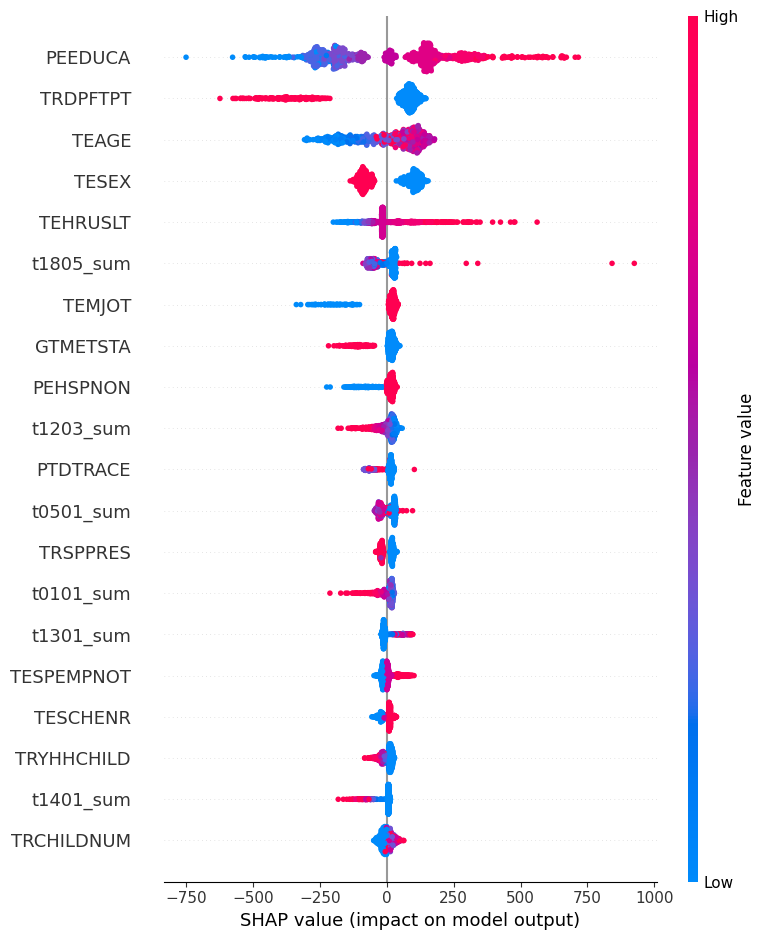

In [17]:
original_feature_names = X_train.columns.tolist()

background = X_train_cnn[np.random.choice(X_train_cnn.shape[0], 1000, replace=False)]
explainer = shap.DeepExplainer(best_model, background)
X_test_cnn_sample = X_test_cnn[np.random.choice(X_test_cnn.shape[0], 1000, replace=False)]
shap_values = explainer.shap_values(X_test_cnn_sample)

X_test_cnn_sample_2d = X_test_cnn_sample.reshape(X_test_cnn_sample.shape[0], -1)
shap_values_2d = np.array(shap_values).reshape(shap_values[0].shape[0], -1)

extended_feature_names = np.tile(original_feature_names, X_train_cnn.shape[1])

shap.summary_plot(shap_values_2d, X_test_cnn_sample_2d, feature_names=extended_feature_names)